In [32]:
# -*- coding: utf-8 -*-
#  Copyright 2024
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Jack S. Callaghan (Bangor University, UK)
#   Reviewed by:  Margaret Duff (STFC-UKRI)

# CPU Simulation and reconstruction using CIL and GVXR

This notebook is used to simulate an X-ray CT scan projections and perform reconstruction on the simulated data.

The scan object is a twisted hexagonal geometry with helical flow channels (object.stl), and the scan parameters are taken from an existing scan (scan_param.xml). The scan parameters in this example are extracted from a [Diondo d5](https://www.diondo.com/en/produkte/diondo-d5) XCT scanner.

The aim is to create a dataset of projections similar to the experiment to:
- practice the reconstruction methods
- prepare the scripting for data import and processing when the raw projection data arrives

gVXR is used to simulate the projections, then the data is written to unsigned 16-bit raw format, which is then read in again and reconstructed.


### Installation
- [environment: CIL CPU](https://github.com/TomographicImaging/CIL)
> conda create --name cilCPU -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.2.0 ipp=2021.12 astra-toolbox=*=py* tigre ccpi-regulariser tomophantom ipykernel ipywidgets scikit-image

- [package: gVXR](https://gvirtualxray.fpvidal.net/)
> pip install --upgrade gvxr

- [package: k3d](https://github.com/K3D-tools/K3D-jupyter)
> conda install -c conda-forge k3d

### Import modules

In [33]:
# CIL - tested on version 24.2.0

import cil
print(cil.__version__)


from cil.framework import AcquisitionData, AcquisitionGeometry, DataContainer
from cil.utilities.display import show_geometry, show2D
from cil.utilities.jupyter import islicer
from cil.plugins.astra import ProjectionOperator
from cil.io import RAWFileWriter
from cil.optimisation.algorithms import CGLS, SIRT
from cil.optimisation.functions import IndicatorBox
from cil.plugins.astra import FBP

# gvxr
import k3d
from gvxrPython3 import gvxr
from gvxrPython3.utils import visualise

# other
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
cmapRecon = "inferno"  


24.2.0


## Read data

The scan parameters and object parameters are found in the xml and stl files, respectively, in the repository. The experimental data is very large, so for the simulation a reduction factor is applied to the projection resolution, and a smaller number of projection angles are used.

First the user specifies the file locations and the data reduction factor: 

In [34]:
# xml name
xmlName = 'scan_param.xml'

# stl name
stlName = 'object.stl'

# data reduction factor (scale down)
dataRed = 15

The XML data is read, setting the scan geometry:

In [35]:
# convert xml as nested dictionary
tree = ET.parse(xmlName)
d = {}
for group in tree.getroot():
    d[group.tag] = {}
    for item in group:
        if item:
            for subitem in item:
                d[group.tag][item.tag] = {}
                d[group.tag][item.tag][subitem.tag] = subitem.text
        else:
            d[group.tag][item.tag] = item.text

# geometry data
numPixX = int(d['ScanParameter']['DetectorPixelX'])
numPixY = int(d['ScanParameter']['DetectorPixelY'])
souPos = float(d['Geometrie']['SourceObjectDist'])
detPos = float(d['Geometrie']['SourceDetectorDist'])
pixSiz = float(d['Recon']['ProjectionPixelSizeX'])
detOffX = float(d['Recon']['ProjectionCenterOffsetX'])
detOffY = float(d['Recon']['ProjectionCenterOffsetY'])

# simulation data - resolution decreased by factor of dataRed
numPixX = int(numPixX / dataRed)
numPixY = int(numPixY / dataRed)
pixSiz = pixSiz * dataRed

# scan data
scaVol = float(d['ScanParameter']['Voltage'])
numPro = int(d['Recon']['ProjectionCount'])


C:\Users\jcc23grt\AppData\Local\Temp\ipykernel_13928\1872668756.py:7: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if item:


The stl file is read and the object viewable in an interactive window: 

In [36]:
plot = k3d.plot()
with open(stlName, "rb") as model:
    plot += k3d.stl(model.read(),color=0xfdea4f)
plot.display()

Output()

## Simulate Projection

The user can determine the number of projections and the end argument. They also set the material of the object being scanned. 

In [37]:
# projection
numPro = 300
endAng = 360

# material
matNam = "ZrO2"
matDen = 5.68     # g/cm3

Using the CIL function `show_geometry`, we can visualise the scan parameters:

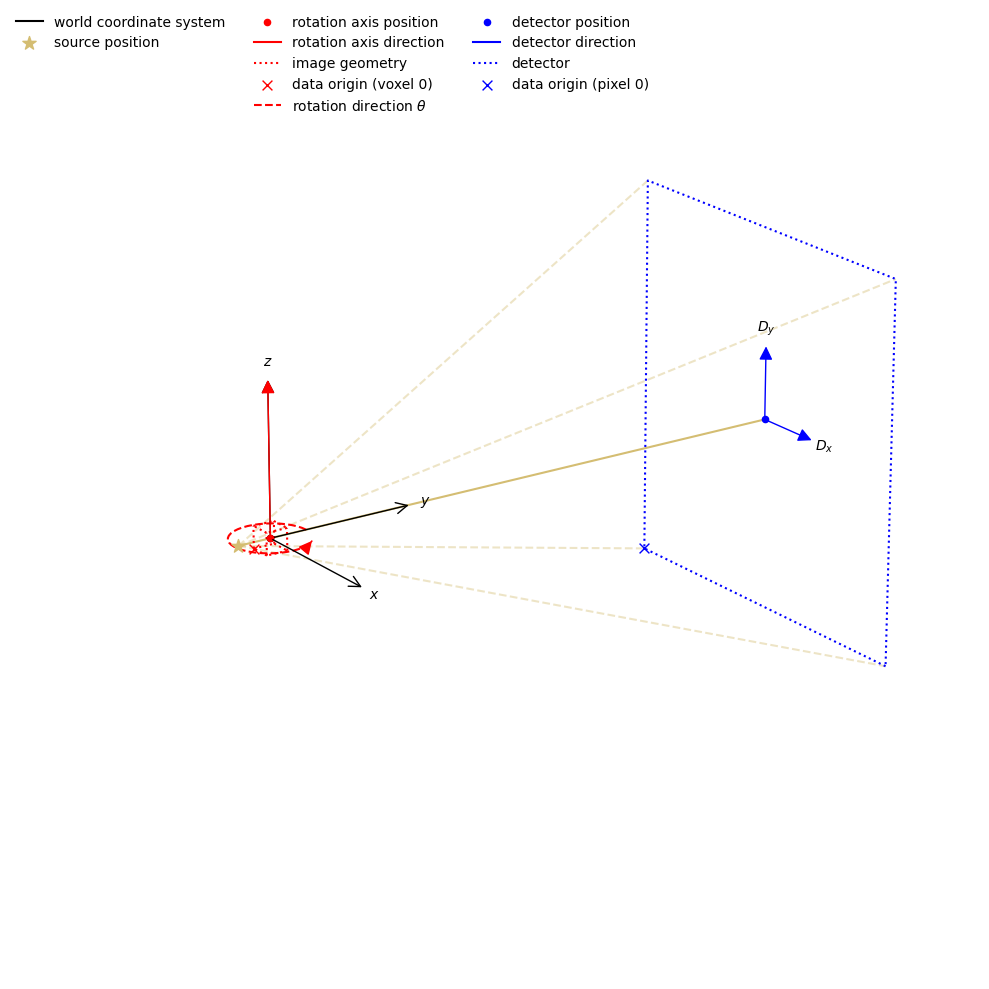

In [38]:
# create geometry
ag = AcquisitionGeometry.create_Cone3D(source_position=[0,-souPos,0],
                                       detector_position=[detOffX,detPos,detOffY])\
    .set_panel(num_pixels=[numPixX,numPixY],pixel_size=pixSiz)\
    .set_angles(angles=np.linspace(0,endAng,numPro,endpoint=False))

# display geometry
show_geometry(ag)

# image geometry
ig = ag.get_ImageGeometry()

The geometry looks feasible and so we can set up GVXR: 

In [39]:
# Create an OpenGL context
window_id = 0
opengl_major_version = 4
opengl_minor_version = 5
backend = "OPENGL"
visible = False
gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version)

# Setup Detector
gvxr.setDetectorNumberOfPixels(numPixX, numPixY)
gvxr.setDetectorPixelSize(pixSiz, pixSiz, "mm")
gvxr.setDetectorUpVector(0, 0, 1)
gvxr.setDetectorPosition(0, detPos, 0, "mm")

# Setup Source
gvxr.setSourcePosition(0,-souPos,0,"mm")
gvxr.usePointSource()
gvxr.addEnergyBinToSpectrum(scaVol, "keV", 1)

# Setup Model
gvxr.removePolygonMeshesFromSceneGraph()
gvxr.loadMeshFile("cell", stlName, "mm")
gvxr.setCompound("cell",matNam)
gvxr.setDensity("cell", matDen, "g/cm3")

Run the virtual scan using GVXR:

In [40]:
gvxr.computeCTAcquisition("", # Where to save the projections
                          "", # Where to save the screenshots
                          numPro, # Total number of projections
                          0, # First angle
                          False, # Include the last angle
                          endAng, # Last angle
                          0, # Number of flat images
                          0, 0, 0, "mm", # Centre of rotation
                          *gvxr.getDetectorUpVector()) # Rotation axis

projSim = np.array(gvxr.getLastProjectionSet())

# Don't forget, we need to use flatfield normalisation on the radiographs to get the correct attenuation values!
# Because our flatfield and darkfield are perfect, all we need to do is divide by the total energy
projSim /= gvxr.getTotalEnergyWithDetectorResponse()

Again using the K3D package, we can visualise again the scan set up alongside one projection:

In [41]:
plot=visualise(use_log=True,)
plot.display()

Output()

We export the projections. This allows us to demonstrate saving and loading projections in GVXR and loading and reconstructing GVXR simulations in CIL

In [42]:
# bit depth
bitDep = 16

# bit depth multiplier
bitMul = (2**bitDep)-1

# admin
filNam = "proj"

# write data to raw - CIL method
imData = DataContainer(projSim, False)
rawWrite = RAWFileWriter(imData,filNam+"_CIL",'uint16')
rawWrite.write()

# write to raw - numpy
projSimNP = projSim * bitMul
projSimNP.astype('uint16').tofile(filNam+"_np.raw")

# Read projections

We now read in the raw projections from the file we just made:

In [43]:
# use simulated or simulated read/write projection data
dataSource = "simRW"        # sim, simRW, exp
dataWriteMethod = "np"      # CIL, np

match(dataSource):
    case "sim":
        print('using sim data')
        proj = projSim
    
    case "exp":
        print('using experimental data')
        
    case "simRW":
        print('using simRW data')

        # get number of pixels
        num_pixels = numPixX * numPixY * numPro

        match(dataWriteMethod):
            case "CIL":
                # Read the .raw file as a numpy array - CIL data
                with open(filNam+"_CIL.raw", "rb") as f:
                    data = np.fromfile(f, dtype=np.uint16, count=num_pixels)

                # normalise data - need to use compression and scale data
                data = (data.astype(float) + 16918.20416302011) / 82453.20416302011
                
            case "np":
                # Read the .raw file as a numpy array - NP data
                with open(filNam+"_np.raw", "rb") as f:
                    data = np.fromfile(f, dtype=np.uint16, count=num_pixels)

                # normalise data
                data = data.astype(float) / bitMul

        # Reshape the data into a 3D array (num_images, height, width)
        projRead = data.reshape((numPro, numPixX, numPixY))

        # reallocate projections
        proj = projRead


using simRW data


We can compare the data we read in to the data we simulated. A snall amount of noise has been added: 

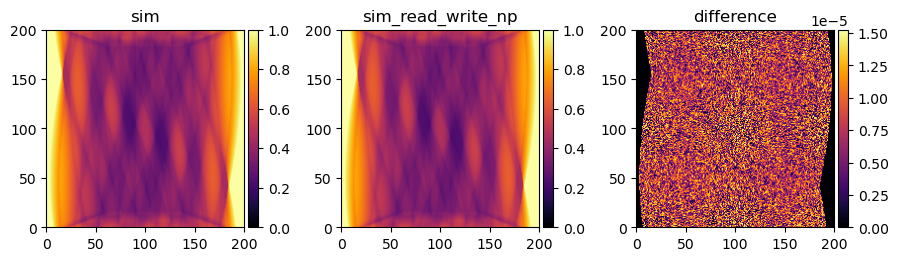

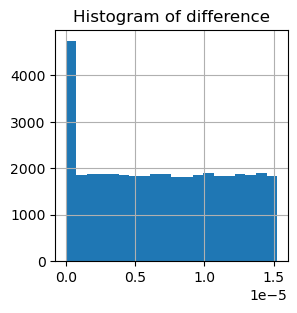

In [44]:
 # plot both and difference
projDiff = projSim[0]-projRead[0]
show2D([projSim[0], projRead[0], projDiff],title=["sim","sim_read_write_"+dataWriteMethod,"difference"],\
        cmap='inferno',num_cols=3,fix_range=[(0,1),(0,1),(projDiff.min(),projDiff.max())], size=(9,3))

plt.figure(figsize=(3,3))
plt.hist(projDiff.ravel(), bins=20)
plt.title("Histogram of difference")
plt.grid('both')
plt.show()

# Reconstruction

We can now reconstruct the simulation in CIL. We first visualise the acquisition data using the CIL islicer:

In [45]:
# colormap
cmapSino = "inferno"    # gray, inferno

# reduce data (64 -> 32 bit)
proj_red = proj.astype(np.float32)
aqData = AcquisitionData(proj_red,False,ag)
islicer(aqData, cmap=cmapSino, direction=1)



Working on the CPU, we cannot reconstruct the whole 3D volume for a cone beam geometry. Instead we reconstruct a single slice:

In [46]:

# get slice
dataSlice = aqData.get_slice(vertical='centre')

# log corecction
dataSlice.log(out=dataSlice)
dataSlice *= -1
#  set up the 2D fandbeam geometry
datageom = dataSlice.geometry
imgeom = datageom.get_ImageGeometry()

We try two basic iterative algorithms, CGLS and SIRT, to reconstruct the image. 

In [47]:

A = ProjectionOperator(imgeom, dataSlice.geometry, device='cpu')

# 'CGLS':
cgls = CGLS(initial=imgeom.allocate(), operator=A, data=dataSlice)
cgls.run(20)
        
# 'SIRT':   
constraint = IndicatorBox(lower=0)
sirt = SIRT(initial=imgeom.allocate(), operator=A, data=dataSlice, constraint=constraint)
sirt.run(500)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Plot

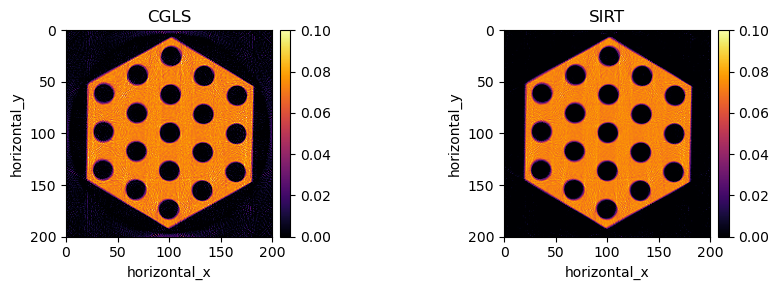

In [48]:
show2D([cgls.solution,sirt.solution], title=["CGLS","SIRT"], cmap=cmapRecon, num_cols=2, origin="upper", fix_range=(0, 0.1), size=(9,3))

CGLS takes many fewer iterations to converge, as expected, and seems to give a sharper image. 